In [3]:
import os
import shutil
import glob
from tqdm import tqdm

import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [4]:
ROOT_DIR = "DATASET_ROOT_DIR" # Change this to your dataset root directory
CONVERTED_IMG_DIR = "DESTINATION_OF_THE_JPEG_IMGS" # Change this to the destination directory of the converted images

DATA_DIR_NAME = "0AS4_data_files"
DATA_DIR = os.path.join(ROOT_DIR, f"{DATA_DIR_NAME}/OASIS4_data_files")
CDR_FILE = os.path.join(DATA_DIR, "CDR/csv/OASIS4_data_CDR.csv")
CDR_C_OF_INTEREST = ["oasis_id", "visit_days", "cdr"]
CLEAR_DESTINATION_DIR = True
SUBJECT_EXCLUDE_TERM = ["BIDS", "Freesurfer"]
NIFTI_DIR_NAME = "NIFTI"
img_cmap = "gray"

In [5]:
def list_subjects(dir, exclude=[]):
    return [os.path.basename(f) for f in glob.glob(os.path.join(dir, '*'))
            if os.path.isdir(f) and os.path.basename(f) not in exclude]

subjects = list_subjects(ROOT_DIR, [DATA_DIR_NAME])

In [6]:
def list_dated_subjects(root_dir, subjects):
    dated_subjects = {}

    for subject in subjects:
        subject_dir = os.path.join(root_dir, subject)
        dated_subjects_dir = glob.glob(os.path.join(subject_dir, '*'))

        dated_subs_structured = []
        for dated_subject_dir in dated_subjects_dir:
            dated_subject_base_name = os.path.basename(dated_subject_dir)
            dated_subject_date = dated_subject_base_name[-4:] # last 4 char
            dated_subs_structured.append({
                "days": int(dated_subject_date),
                "dir": dated_subject_base_name
            })

        dated_subjects[subject] = dated_subs_structured

    return dated_subjects

dated_subjects = list_dated_subjects(ROOT_DIR, subjects)

In [7]:
def get_sequence_dir(dir, exclude=[]):
    return [os.path.basename(f) for f in glob.glob(os.path.join(dir, '*'))
            if os.path.isdir(f) and all(ex.lower() not in os.path.basename(f).lower() for ex in exclude)]

dated_subjects_with_sequence = {}

for k, v in dated_subjects.items():
    for item in v:
        scan_dir = os.path.join(ROOT_DIR, k, item["dir"])
        sequence_dir = get_sequence_dir(scan_dir, SUBJECT_EXCLUDE_TERM)
        item["sequence"] = sequence_dir

    dated_subjects_with_sequence[k] = v

In [8]:
subjects_with_nifti_files = {}

for k, v in dated_subjects_with_sequence.items():
    for item in v:
        nifti_list = []
        for sequence in item["sequence"]:
            sequence_dir = os.path.join(ROOT_DIR, k, item["dir"], sequence)
            nifti_dir = os.path.join(sequence_dir, NIFTI_DIR_NAME)
            nifti_files = glob.glob(os.path.join(nifti_dir, '*.nii.gz'))
            assert len(nifti_files) > 0, "No NIFTI file found"
            nifti_files_names = [os.path.basename(f) for f in nifti_files]
            nifti_list.append({sequence: nifti_files_names})
        item["nifti_files"] = nifti_list
    subjects_with_nifti_files[k] = v

In [9]:
def get_optimal_cdr(df_, subject_id, visit_days):
    df__ = df_[df_[CDR_C_OF_INTEREST[0]] == subject_id]
    if df__.empty:
        return -1
    df__['diff'] = abs(df__[CDR_C_OF_INTEREST[1]] - visit_days)
    row_idx_ = df__['diff'].idxmin()
    cdr_ = df__.loc[row_idx_, CDR_C_OF_INTEREST[2]]
    cdr_ = cdr_.astype(np.float32)
    return cdr_

In [10]:
cdr_df = pd.read_csv(CDR_FILE, usecols=CDR_C_OF_INTEREST)
cdr_df.head()

,oasis_id,visit_days,cdr
0,OAS42000,3000,0.5
1,OAS42001,3392,0.5
2,OAS42001,3000,0.5
3,OAS42001,3203,0.5
4,OAS42002,3000,0.5


In [11]:
missing_values_df = cdr_df[cdr_df.isna().any(axis=1)]
subjects_with_missing_values = missing_values_df["oasis_id"].values

for item in subjects_with_missing_values:
    if item in subjects_with_nifti_files:
        del subjects_with_nifti_files[item]

cdr_df = cdr_df.dropna()

In [12]:
subjects_with_cdr = {}

missing_val_subjs = []

for k, v in subjects_with_nifti_files.items():
    for item in v:
        opt_cdr = get_optimal_cdr(cdr_df, k, item["days"])
        if opt_cdr == -1:
            missing_val_subjs.append(k)
        item["cdr"] = opt_cdr
    subjects_with_cdr[k] = v

for item in missing_val_subjs:
    if item in subjects_with_cdr:
        del subjects_with_cdr[item]

In [13]:
cdr_scale = { # ref: https://knightadrc.wustl.edu/professionals-clinicians/cdr-dementia-staging-instrument/cdr-scoring-table/
    "normal": 0,
    "very_mild_dimentia": 0.5,
    "mild_dimentia": 1,
    "moderate_dimentia": 2,
    "severe_dimentia": 3,
}

def get_cdr_label(cdr_val):
    for k, v in cdr_scale.items():
        if v == cdr_val:
            return k
    return None

In [14]:
if CLEAR_DESTINATION_DIR:
    if os.path.exists(CONVERTED_IMG_DIR):
      shutil.rmtree(CONVERTED_IMG_DIR)

for k, _ in cdr_scale.items():
    label_dir_ = os.path.join(CONVERTED_IMG_DIR, k)
    if not os.path.exists(label_dir_):
        os.makedirs(label_dir_)

In [15]:
def show_and_save_nifti(file, fname = None, save_dir = None):
    data = nib.load(file).get_fdata()
    data = data.astype(np.float32)
    if data.ndim == 3:
        img_data = data[:, :, data.shape[2]//2] # middle slice
    elif data.ndim == 4:
        img_data = data[:, :, data.shape[2]//2, data.shape[3]//2] # middle slice
    else:
        print(f"Invalid dimension: {data.ndim} and shape: {data.shape}")
        return
    img_data = (img_data - img_data.min()) / (img_data.max() - img_data.min())
    plt.imshow(img_data, cmap="gray")
    plt.axis('off')
    if fname is not None and save_dir is not None:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, fname)
        if os.path.exists(save_path):
            os.remove(save_path)
        plt.savefig(save_path, bbox_inches="tight", pad_inches=0)

Subject-wise progress: 100%|██████████| 2/2 [00:20<00:00, 10.22s/it]


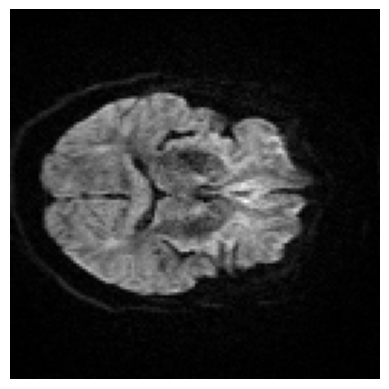

In [16]:
for k, v in tqdm(subjects_with_cdr.items(), "Subject-wise progress"):
    for item in v:
        cdr_ = item["cdr"]
        cdr_label = get_cdr_label(cdr_)

        dir_ = item["dir"]
        nifti_files_ = item["nifti_files"]

        for nifti_file_ in tqdm(nifti_files_, f"{k}-NIFTI"):
            for k_n, v_n in nifti_file_.items():
                for nifti_file_path in v_n:
                    fname_ = os.path.splitext(os.path.splitext(nifti_file_path)[0])[0]
                    fname_ = f"{fname_}.jpg"
                    save_dir_ = os.path.join(CONVERTED_IMG_DIR, cdr_label, k, dir_, k_n)
                    nii_full_path = os.path.join(ROOT_DIR, k, dir_, k_n, NIFTI_DIR_NAME, nifti_file_path)
                    show_and_save_nifti(nii_full_path, fname_, save_dir_)

In [ ]:
num_jpg_files = glob.glob(os.path.join(CONVERTED_IMG_DIR, '**/*.jpg'), recursive=True)
print(f"Total {len(num_jpg_files)} images extracted.")